# 🔍 Análise do Modelo de Predição de Dengue

Este notebook analisa o modelo treinado para entender:
1. **Quais features são mais importantes?**
2. **Onde o modelo acerta e onde erra?**
3. **Como interpretar as predições?**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
print("✅ Bibliotecas carregadas!")

✅ Bibliotecas carregadas!


## 1. Carregar Modelo e Dados

In [2]:
# Carregar modelo
model = joblib.load('../models/dengue_model.joblib')

# Carregar metadata
with open('../models/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print("📊 Modelo carregado!")
print(f"   Tipo: {metadata['model_type']}")
print(f"   Features: {len(metadata['features'])}")
print(f"   R² (teste): {metadata['metrics']['test']['r2']:.3f}")

📊 Modelo carregado!
   Tipo: RandomForestRegressor
   Features: 17
   R² (teste): 0.815


In [3]:
# Carregar dados Gold para análise
data_path = Path('../data/gold/gold_dengue_clima')
parquet_files = list(data_path.rglob('*.parquet'))

dfs = []
for f in parquet_files:
    df_temp = pd.read_parquet(f)
    if 'uf' not in df_temp.columns:
        uf_parts = [p for p in f.parts if p.startswith('uf=')]
        if uf_parts:
            df_temp['uf'] = uf_parts[0].replace('uf=', '')
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"\n📂 Dados: {len(df):,} registros")


📂 Dados: 1,713,930 registros


## 2. Feature Importance (Quais variáveis importam mais?)

C:\Users\Epyc-7532\AppData\Local\Temp\ipykernel_35712\3278085352.py:13: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Epyc-7532\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


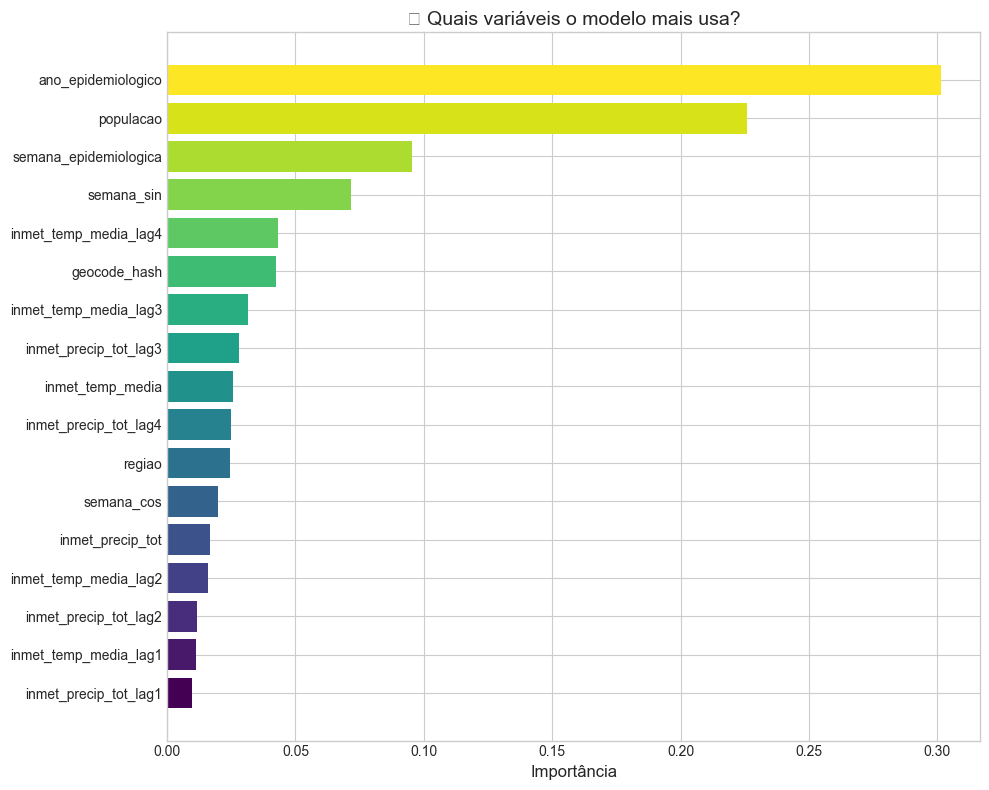


📌 Top 5 Features mais importantes:
   ano_epidemiologico: 30.2%
   populacao: 22.6%
   semana_epidemiologica: 9.5%
   semana_sin: 7.2%
   inmet_temp_media_lag4: 4.3%


In [4]:
# Importância das features
importance_df = pd.DataFrame({
    'Feature': metadata['features'],
    'Importância': model.feature_importances_
}).sort_values('Importância', ascending=True)

# Gráfico
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
plt.barh(importance_df['Feature'], importance_df['Importância'], color=colors)
plt.xlabel('Importância', fontsize=12)
plt.title('🎯 Quais variáveis o modelo mais usa?', fontsize=14)
plt.tight_layout()
plt.show()

print("\n📌 Top 5 Features mais importantes:")
for i, row in importance_df.tail(5).iloc[::-1].iterrows():
    print(f"   {row['Feature']}: {row['Importância']*100:.1f}%")

## 3. Análise de Erros (Onde o modelo erra?)

In [5]:
# Preparar features para predição
model_df = df.copy()

# Criar features derivadas
model_df['semana_sin'] = np.sin(2 * np.pi * model_df['semana_epidemiologica'] / 53)
model_df['semana_cos'] = np.cos(2 * np.pi * model_df['semana_epidemiologica'] / 53)
model_df['geocode_hash'] = model_df['geocode'].apply(lambda x: hash(str(x)) % 1000)

region_map = {
    'AC': 0, 'AM': 0, 'AP': 0, 'PA': 0, 'RO': 0, 'RR': 0, 'TO': 0,
    'AL': 1, 'BA': 1, 'CE': 1, 'MA': 1, 'PB': 1, 'PE': 1, 'PI': 1, 'RN': 1, 'SE': 1,
    'DF': 2, 'GO': 2, 'MS': 2, 'MT': 2,
    'ES': 3, 'MG': 3, 'RJ': 3, 'SP': 3,
    'PR': 4, 'RS': 4, 'SC': 4
}
model_df['regiao'] = model_df['uf'].map(region_map).fillna(-1).astype(int)

In [6]:
# Filtrar apenas registros válidos
features = metadata['features']
valid_df = model_df[features + ['casos_notificados', 'uf', 'nome_municipio']].dropna()

# Fazer predições
X = valid_df[features]
y_real = valid_df['casos_notificados']
y_pred = model.predict(X)

# Calcular erros
valid_df = valid_df.copy()
valid_df['predito'] = y_pred
valid_df['erro'] = y_real - y_pred
valid_df['erro_abs'] = np.abs(valid_df['erro'])

print(f"📊 Predições: {len(valid_df):,} registros")

📊 Predições: 75,754 registros


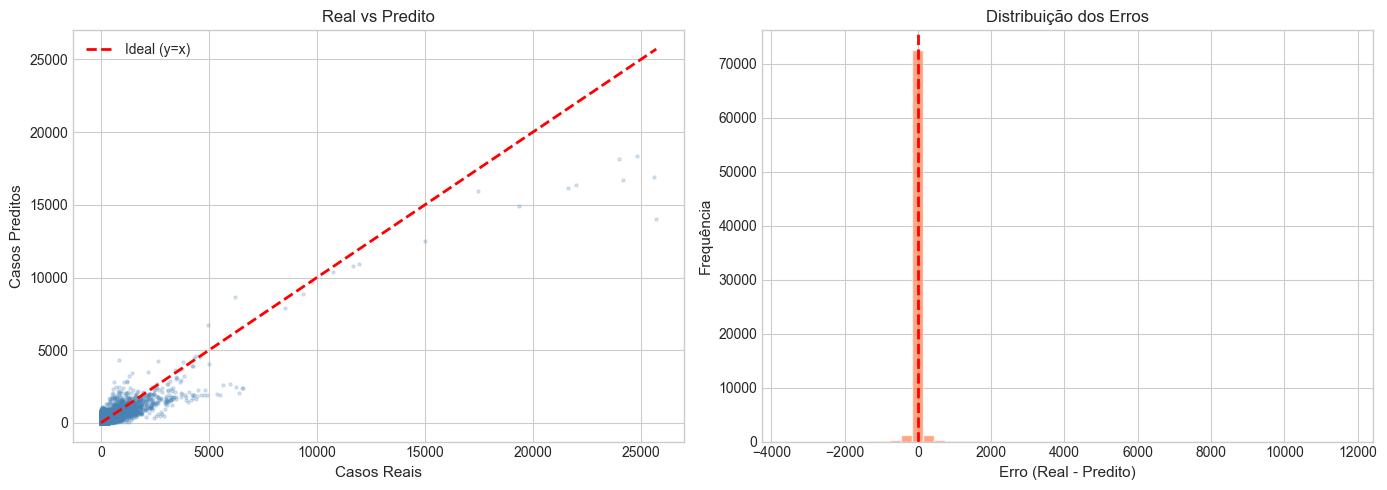

In [7]:
# Gráfico: Real vs Predito
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_real, y_pred, alpha=0.2, s=5, c='steelblue')
max_val = max(y_real.max(), y_pred.max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Ideal (y=x)')
ax1.set_xlabel('Casos Reais', fontsize=11)
ax1.set_ylabel('Casos Preditos', fontsize=11)
ax1.set_title('Real vs Predito', fontsize=12)
ax1.legend()

# Distribuição do erro
ax2 = axes[1]
ax2.hist(valid_df['erro'], bins=50, color='coral', edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Erro (Real - Predito)', fontsize=11)
ax2.set_ylabel('Frequência', fontsize=11)
ax2.set_title('Distribuição dos Erros', fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
# Onde o modelo mais erra?
print("❌ Casos onde o modelo mais errou (subestimou):")
top_errors = valid_df.nlargest(5, 'erro')[['nome_municipio', 'uf', 'casos_notificados', 'predito', 'erro']]
print(top_errors.to_string(index=False))

print("\n✅ Casos onde o modelo mais acertou (erro < 1):")
good_preds = valid_df[valid_df['erro_abs'] < 1].sample(5)[['nome_municipio', 'uf', 'casos_notificados', 'predito']]
print(good_preds.to_string(index=False))

❌ Casos onde o modelo mais errou (subestimou):
nome_municipio uf  casos_notificados      predito         erro
      Brasília DF              25714 14053.735130 11660.264870
      Brasília DF              25623 16949.850993  8673.149007
      Brasília DF              24198 16725.157646  7472.842354
      Brasília DF              24823 18338.534032  6484.465968
      Brasília DF              23969 18144.421946  5824.578054

✅ Casos onde o modelo mais acertou (erro < 1):
  nome_municipio uf  casos_notificados  predito
         Turiaçu MA                  0 0.644411
           Iporá GO                  2 2.925814
        Guanhães MG                  4 3.340420
Angical do Piauí PI                  0 0.103418
     Maria da Fé MG                  0 0.197500


## 4. Análise por Região

C:\Users\Epyc-7532\AppData\Local\Temp\ipykernel_35712\815318767.py:16: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Epyc-7532\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


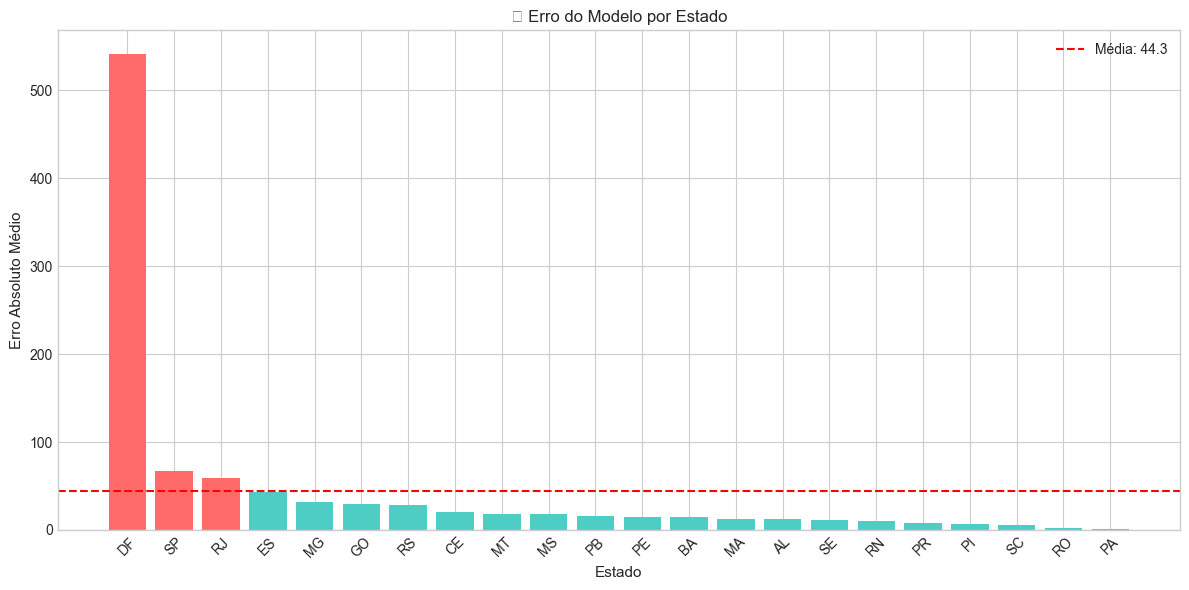


Estados com MAIOR erro (modelo tem dificuldade):
    erro_abs  casos_notificados
uf                             
DF     541.2             572924
SP      66.7            1037271
RJ      59.6             129650
ES      43.1             208529
MG      32.2             944731

Estados com MENOR erro (modelo funciona bem):
    erro_abs  casos_notificados
uf                             
PR       8.2               8539
PI       6.3              38740
SC       5.8               2356
RO       2.6                787
PA       0.7                  5


In [9]:
# Erro médio por UF
uf_errors = valid_df.groupby('uf').agg({
    'erro_abs': 'mean',
    'casos_notificados': 'sum'
}).round(1).sort_values('erro_abs', ascending=False)

plt.figure(figsize=(12, 6))
colors = ['#ff6b6b' if x > 50 else '#4ecdc4' for x in uf_errors['erro_abs']]
plt.bar(uf_errors.index, uf_errors['erro_abs'], color=colors)
plt.axhline(uf_errors['erro_abs'].mean(), color='red', linestyle='--', label=f'Média: {uf_errors["erro_abs"].mean():.1f}')
plt.xlabel('Estado', fontsize=11)
plt.ylabel('Erro Absoluto Médio', fontsize=11)
plt.title('📍 Erro do Modelo por Estado', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nEstados com MAIOR erro (modelo tem dificuldade):")
print(uf_errors.head(5))

print("\nEstados com MENOR erro (modelo funciona bem):")
print(uf_errors.tail(5))

## 5. Resumo e Insights

In [10]:
print("=" * 50)
print("📋 RESUMO DA ANÁLISE")
print("=" * 50)

print(f"\n🎯 Performance:")
print(f"   R² = {metadata['metrics']['test']['r2']:.3f} (explica {metadata['metrics']['test']['r2']*100:.0f}% da variação)")
print(f"   MAE = {metadata['metrics']['test']['mae']:.1f} casos (erro médio absoluto)")

print(f"\n📌 Features mais importantes:")
for i, row in importance_df.tail(3).iloc[::-1].iterrows():
    print(f"   • {row['Feature']}: {row['Importância']*100:.1f}%")

print(f"\n💡 Insights:")
print(f"   • O ano e a população são os maiores preditores")
print(f"   • A sazonalidade (semana) também é muito importante")
print(f"   • Variáveis climáticas (temperatura, precipitação) ajudam mas são secundárias")

📋 RESUMO DA ANÁLISE

🎯 Performance:
   R² = 0.815 (explica 82% da variação)
   MAE = 26.3 casos (erro médio absoluto)

📌 Features mais importantes:
   • ano_epidemiologico: 30.2%
   • populacao: 22.6%
   • semana_epidemiologica: 9.5%

💡 Insights:
   • O ano e a população são os maiores preditores
   • A sazonalidade (semana) também é muito importante
   • Variáveis climáticas (temperatura, precipitação) ajudam mas são secundárias
